# Sentiment Analysis for Financial News

This is a project in natural language processing as part of a course in Unsupervised Learning taken at the Univeristy of Colorado at Boulder. The dataset is from Kaggle and can be found at https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download. The intent of this project is to explore whether or not financial news stories can be reliably modeled in order to discern the sentiment of the text, between positive, neutral, and negative categories. The possible applications for this would be signal generation for investment/allocation strategies.

### Import Required Libraries

We start by importing various required (probably some unnecessary libraries are included here..) libraries for the notebook. **NOTE that you may need to uncomment the first cell below if you do not have nltk installed. First, open a cmd prompt and execute "pip install nltk" An additional pop-up window may then open once you execute the cell below and you can select Download. Finally, you may also need to exectute "pip install gensim" in a cmd window if you have not already installed that package. The goal is to execute the cell with all the import/from directives without error.

In [120]:
#import nltk
#nltk.download()

In [121]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
import nltk
import sklearn
import re
import copy

from collections import  Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.decomposition import NMF
from gensim.models import Word2Vec

### Import Data

In [122]:
train_data = pd.read_csv('all-data.csv', encoding='unicode_escape')

## 1) EDA, Data Cleaning, and Pre-processing

#### 1a - EDA

##### The data consists of a training file with 4,846 entries, consisting of two columns Sentiment and Text. As see from the .head execution, Sentiment is a string that can take values of neutral, positive, and negative, and represents the sentiment associated with the Text, which is simply raw news text.

In [123]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Text       4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [124]:
train_data.head

<bound method NDFrame.head of      Sentiment                                               Text
0      neutral  According to Gran , the company has no plans t...
1      neutral  Technopolis plans to develop in stages an area...
2     negative  The international electronic industry company ...
3     positive  With the new production plant the company woul...
4     positive  According to the company 's updated strategy f...
...        ...                                                ...
4841  negative  LONDON MarketWatch -- Share prices ended lower...
4842   neutral  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843  negative  Operating profit fell to EUR 35.4 mn from EUR ...
4844  negative  Net sales of the Paper segment decreased to EU...
4845  negative  Sales in Finland decreased by 10.5 % in Januar...

[4846 rows x 2 columns]>

##### First, let's take a look if any of the training data is missing values across any of the variables. We find that we aren't missing any values.

In [125]:
train_data.isnull().sum()

Sentiment    0
Text         0
dtype: int64

#### 1b - Cleaning

##### Since we don't have any obvious bad values to clean out, we'll at least add a more easily applied numeric column to denote the categories, rather than their raw strings. We can do this easily using the factorize() method.

In [126]:
train_data['sentimentId'] = train_data['Sentiment'].factorize()[0]

In [127]:
train_data.head(5)

,Sentiment,Text,sentimentId
0,neutral,"According to Gran , the company has no plans t...",0
1,neutral,Technopolis plans to develop in stages an area...,0
2,negative,The international electronic industry company ...,1
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


##### Now, take a look at how many articles of each category we are dealing with. Perhaps unsurprisingly, we find that most articles can be considered to have neutral sentiment, while negative articles are noticeably less frequent that the other categories. Although it's probably not to a degree that you could considered the data to be heavily imbalanced, we will nevertheless move forward with an eye to being careful to stratify our data handling.

In [128]:
train_data.groupby('Sentiment').sentimentId.count()

Sentiment
negative     604
neutral     2879
positive    1363
Name: sentimentId, dtype: int64

##### This is just a plot of what was found above, the frequencies of each sentiment category in the training data.

Text(0.5, 1.0, 'Frequencies of Financial Sentiment Categories')

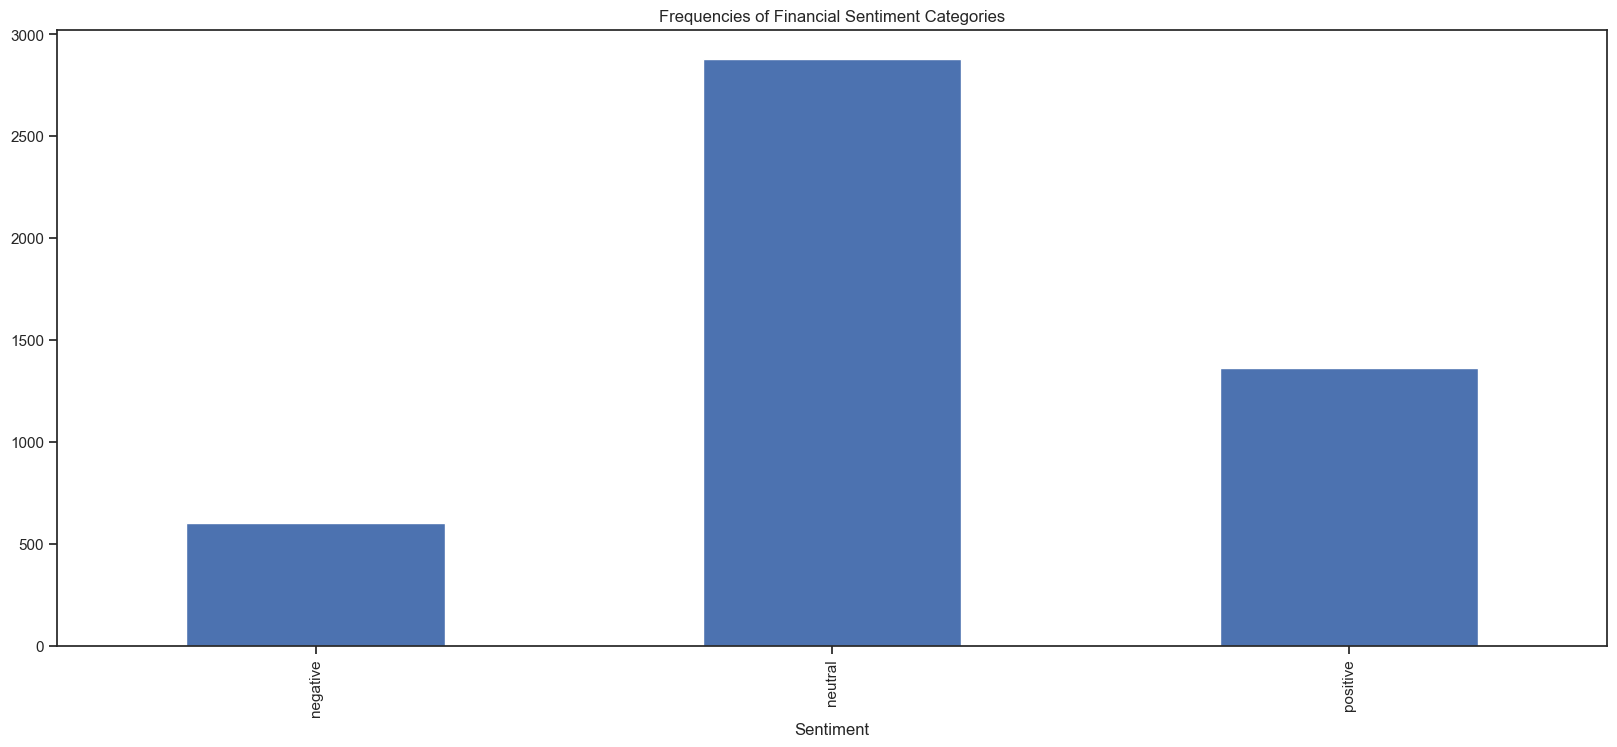

In [129]:
train_data.groupby('Sentiment').sentimentId.count().plot.bar(ylim=0)
plt.title("Frequencies of Financial Sentiment Categories")

#### 1c - Preprocessing

##### A note on NLTK

NLTK is the Natural Language ToolKit. A good intro to lemmatization can be found here: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/. In short, lemmatization attempts to transform words to their most meaningful/comparative representation across objects. A fantastic augmented text file of stopwords was found at https://gist.github.com/sebleier/554280. This adds to the standard NLTK list of stopwords some obvious choices such as "said". We will use this list rather than the default list available in the NLTK.

##### Import the custom stopwords

In [130]:
# This is the file of augmented stop words vs the standard corpus available in the nltk.
gist_file = open("gist_stopwords.txt", "r")
try:
    content = gist_file.read()
    custom_stop = content.split(",")
finally:
    gist_file.close()

##### Set up the function for preprocessing the data. We will embed the punctuation and numeric regex in the function, but pass the stopwords as an argument so we can toggle that as desired. Also note that when we lemmatize the text, we put this as its own column rather than modifying Text_Clean in place so that we can key off those in isolation subsequently.

In [131]:
def preprocess_rawtext(raw_data, stopwords):
    # Casing
    raw_data["Text_Clean"] = [txt.lower() for txt in raw_data['Text']]
    # Punctuations
    raw_data["Text_Clean"] = raw_data['Text_Clean'].str.replace('[^\w\s]','',regex=True)
    # Numeric characters
    raw_data["Text_Clean"] = raw_data["Text_Clean"].str.replace('\d+','',regex=True)
    # Stopwords
    raw_data['Text_Clean'] = raw_data['Text_Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # Extra spaces
    raw_data['Text_Clean'] = raw_data['Text_Clean'].apply(lambda x: re.sub(' +', ' ', x))
    # lemmatize words (see note above for link to descriptioon of lemmatization)
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    def lemmatize_text(text):
        lem_text = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
        return " ".join(lem_text)
    raw_data['Text_Lemmatized'] = raw_data['Text_Clean'].apply(lemmatize_text)
    

In [132]:
preprocess_rawtext(train_data, custom_stop)

In [133]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment        4846 non-null   object
 1   Text             4846 non-null   object
 2   sentimentId      4846 non-null   int64 
 3   Text_Clean       4846 non-null   object
 4   Text_Lemmatized  4846 non-null   object
dtypes: int64(1), object(4)
memory usage: 189.4+ KB


##### Let's visualize the top 20 words from the lemmatized text.

In [134]:
def top_frequent_words(data, title):
    data_split= data.str.split()
    data_list=data_split.values.tolist()
    corpus=[word for i in data_list for word in i]
    counter=Counter(corpus)
    mostCommon=counter.most_common()
    x, y=[], []
    for word,count in mostCommon[:20]:
        if (word not in set(custom_stop)):
            x.append(word)
            y.append(count) 
    sns.set(rc={"figure.figsize":(20, 8)}) #width=3, #height=4
    sns.set_style("ticks")
    plot = sns.barplot(x=x,y=y)
    plt.title(title,fontsize=30)
    plt.xticks(rotation=45)
    plt.tick_params(labelsize = 20)


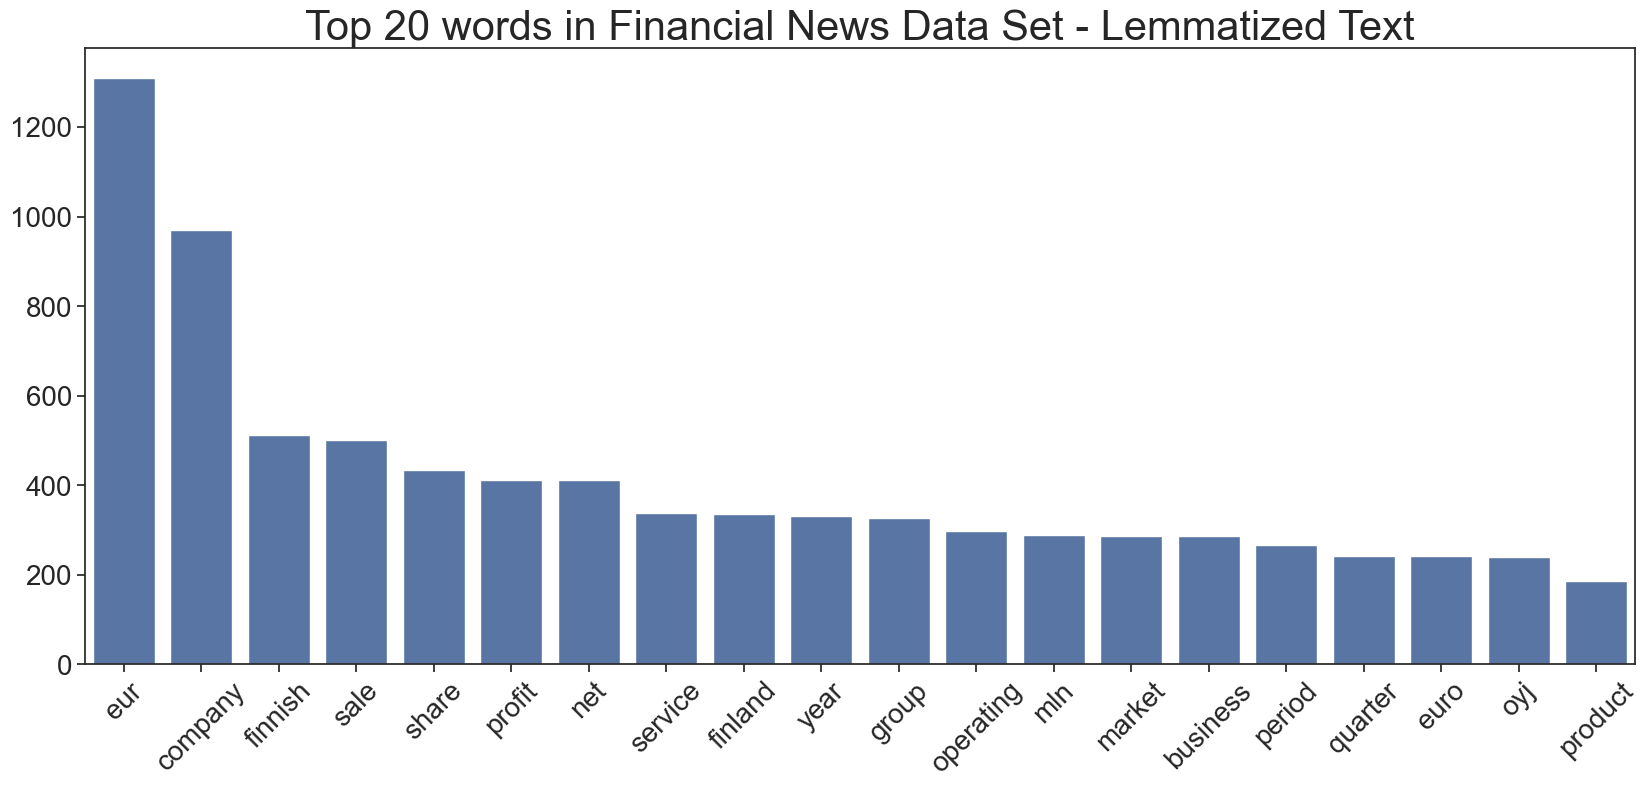

In [135]:
top_frequent_words(train_data['Text_Lemmatized'], 'Top 20 words in Financial News Data Set - Lemmatized Text')

##### Just as a quick illustration of some lemmatizing that goes on, here is a head view of the clean text and then the lemmatized text. Note the first change in text 1 is that "plans" becomes "plan". Unfortunately there aren't great non-plural examples of lemmatization to see here, i.e. "abaci" to "abacus", for example.

In [137]:
train_data['Text_Clean'].head

<bound method NDFrame.head of 0       gran company plans production russia company g...
1       technopolis plans develop stages area square m...
2       international electronic industry company elco...
3       production plant company increase capacity mee...
4       company updated strategy years basware targets...
                              ...                        
4841    london marketwatch share prices ended lower lo...
4842    rinkuskiai beer sales fell cent litres kauno a...
4843    operating profit fell eur eur including vessel...
4844    net sales paper segment decreased eur quarter ...
4845    sales finland decreased january sales finland ...
Name: Text_Clean, Length: 4846, dtype: object>

In [136]:
train_data['Text_Lemmatized'].head

<bound method NDFrame.head of 0       gran company plan production russia company gr...
1       technopolis plan develop stage area square met...
2       international electronic industry company elco...
3       production plant company increase capacity mee...
4       company updated strategy year basware target l...
                              ...                        
4841    london marketwatch share price ended lower lon...
4842    rinkuskiai beer sale fell cent litre kauno alu...
4843    operating profit fell eur eur including vessel...
4844    net sale paper segment decreased eur quarter e...
4845    sale finland decreased january sale finland dr...
Name: Text_Lemmatized, Length: 4846, dtype: object>

## 2) Modelling - TF-IDF Vectorization

##### This is just a function to find the optimal labelling permutation from the unsupervised models. Unsupervised models tend to output results to random categories, so you can then permute these results to obtain an optimal mapping back to the ground truth categories.

In [138]:
def label_permute_compare(ytdf, yp, n=5):

    # Get a list of lists that permutes the prediction labels
    yp_perms = list(itertools.permutations(np.unique(yp)))

    # Convert true labels to numeric labels
    perm_ref = range(n)
    true_labs = np.unique(ytdf)
    ytdf_num = [perm_ref[np.where(true_labs == ytdf_i)[0][0]] for ytdf_i in ytdf]
    
    # Initialize best accuracy and permutation
    best_accuracy = 0
    best_order = ()
    
    # Iterate and swap with permutations, storing best accuracy
    swap_buffer = n * 2 + 1
    for perm in yp_perms:
        yp_temp = yp.copy()
        perm = np.array(perm)
        for i in range(len(yp_temp)):
            yp_temp[i] = perm[yp_temp[i]] + swap_buffer
        reordered = [x - swap_buffer for x in yp_temp]
        acc = accuracy_score(ytdf_num, reordered)
        # Store if we're at best so far
        if acc > best_accuracy:
            best_accuracy = acc
            best_order = perm

    labeled_dic = dict()
    for i in range(len(best_order)):
        labeled_dic.update( { true_labs[i] : best_order[i] } )

    return labeled_dic, best_accuracy

In [139]:
# Set the number of topics to the number of unique categories in the data
n_topics = len(train_data.groupby('Sentiment').sentimentId.count())

#### 2a) Unsupervised Learning: Non-Negative Matrix Factorization (NMF)

##### We start with using NMF on features that have been transformed using tf-idf, or text frequency-inverse document frequency method. TF-IDF is a popular and intuitive method that weights words that are in-text frequent, but across-text infrequent as being more important. More details on this method can be easily found from a Google search.

In [140]:
# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])

# Set up tf-idf vectorizer. We start with some arbitrary choices of the hyperparameters max_features, min_df, and max_df, but will revisit these later.
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          max_features=5000,
                          min_df=2,
                          max_df=0.95,
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')

# Set up NMF. We start with some arbitrary choices of the hyperparameters alpha_w and alpha_h, but will revisit these later.
nmf = NMF(
    n_components=n_topics, 
    random_state=0, 
    init = "nndsvda", 
    beta_loss="frobenius",
    alpha_W=0.001,
    alpha_H=0.001,
    )

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using NMF, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the tfidf model to the iteration's training data and also create testing features
    train_features = tfidvec.fit_transform(x_train_fold).toarray() 
    test_features = tfidvec.transform(x_test_fold).toarray() 
    # Fit the nmf model to the training tf-idf vector
    nmf.fit(train_features)
    # Use the fitted nmf model to predict based on the test tf-idf vector
    nmf_test_predict = np.argmax(nmf.transform(test_features), axis = 1)
    y_pred_skf.extend(nmf_test_predict)
    y_test_skf.extend(y_test_fold)


##### Get the optimal label orderings and accuracy.

In [141]:
test_labelorder, test_acc = label_permute_compare(y_test_skf, y_pred_skf, n_topics)
print(test_labelorder, test_acc)

{0: 1, 1: 2, 2: 0} 0.46450680973999176


##### Plot confusion matrix for the test predictions

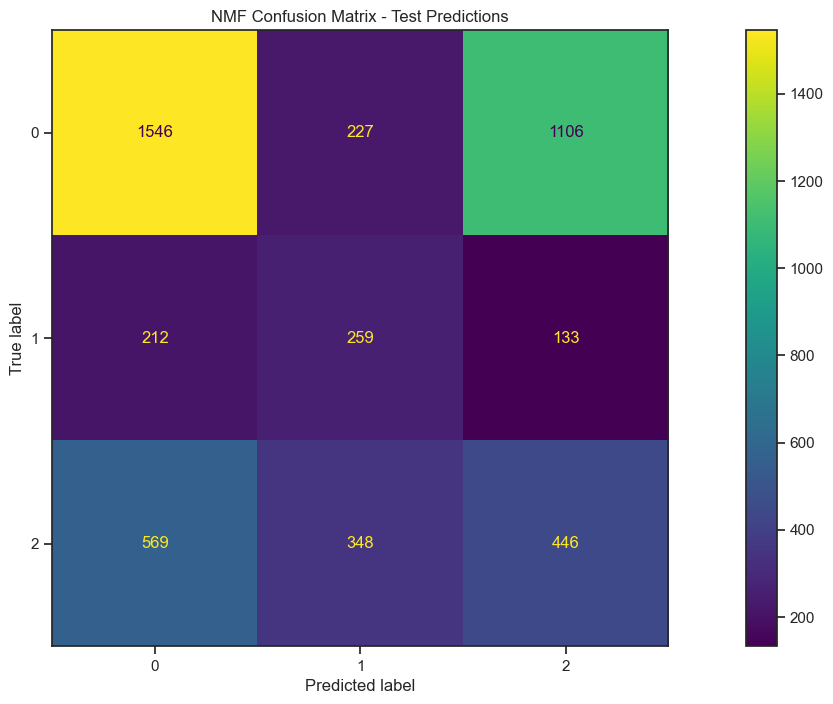

In [142]:
# Get an adjusted label set given the NMF-derived labelorer found above
perm_ref = list(range(len(np.unique(y_test_skf))))
true_labs = np.unique(y_test_skf)
yp_adj = [list(test_labelorder.values())[np.where(perm_ref == label_i)[0][0]] for label_i in y_pred_skf]
ytdf_num = [perm_ref[np.where(true_labs == ytdf_i)[0][0]] for ytdf_i in y_test_skf]

# Use sklearn's ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true = ytdf_num, y_pred = yp_adj)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = test_labelorder.keys())
disp.plot(values_format='')
plt.title('NMF Confusion Matrix - Test Predictions')
plt.show()

#### Trying different hyperparameter choices for tf-idf as input to NMF model

In [143]:
max_feature_vec = [1000, 2000, 3000, 4000, 5000]
min_df_vec = [2, 3, 5]
max_df_vec = [0.8, 0.9, 0.95, 0.98]
alpha_W_vec = [0.001, 0.005]
alpha_H_vec = [0.001, 0.005]
results = []

for mfv in max_feature_vec:
    for mdv in min_df_vec:
        for mxv in max_df_vec:
            for awv in alpha_W_vec:
                for ahv in alpha_H_vec:
                    
                    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
                    skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])
                    
                    tfidvec = TfidfVectorizer(sublinear_tf=True,
                                              max_features=mfv,
                                              min_df=mdv,
                                              max_df=mxv,
                                              norm='l2', 
                                              encoding='latin-1', 
                                              ngram_range=(1, 2), 
                                              stop_words='english')
                    
                    nmf = NMF(
                        n_components=n_topics, 
                        random_state=0, 
                        init = "nndsvda", 
                        beta_loss="frobenius",
                        alpha_W=awv,
                        alpha_H=ahv,
                        )
                    
                    y_test_skf = []
                    y_pred_skf = []
                    
                    for train_index, test_index in skf_split:
                        x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
                        y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
                        # Fit the tfidf model to the iteration's training data and also create testing features
                        train_features = tfidvec.fit_transform(x_train_fold).toarray() 
                        test_features = tfidvec.transform(x_test_fold).toarray() 
                        # Fit the nmf model to the training tf-idf vector
                        nmf.fit(train_features)
                        # Use the fitted nmf model to predict based on the test tf-idf vector
                        nmf_test_predict = np.argmax(nmf.transform(test_features), axis = 1)
                        y_pred_skf.extend(nmf_test_predict)
                        y_test_skf.extend(y_test_fold)

                    labelorder, acc = label_permute_compare(y_test_skf, y_pred_skf, n_topics)

                    results.append((mfv, mdv, mxv, awv, ahv, acc))

print(max(results, key=lambda x:x[5]))

(3000, 2, 0.8, 0.001, 0.001, 0.6044160132067685)


##### Run the model with the optimal hyperparameters found above and plot CM

{0: 1, 1: 0, 2: 2} 0.6044160132067685


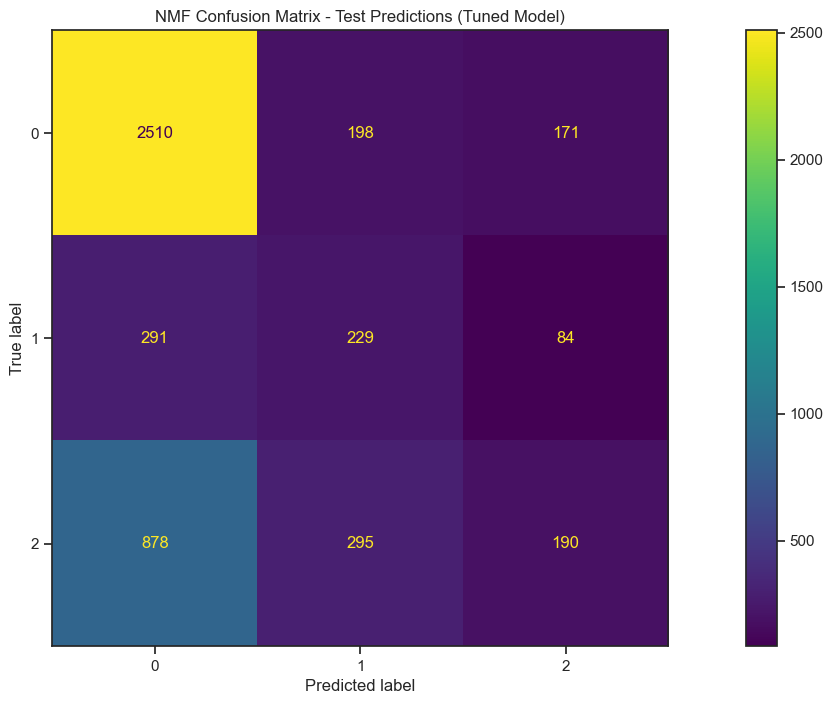

In [144]:
# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])

# Set up tf-idf vectorizer. We start with some arbitrary choices of the hyperparameters max_features, min_df, and max_df, but will revisit these later.
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          max_features=3000,
                          min_df=2,
                          max_df=0.8,
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')

# Set up NMF. We start with some arbitrary choices of the hyperparameters alpha_w and alpha_h, but will revisit these later.
nmf = NMF(
    n_components=n_topics, 
    random_state=0, 
    init = "nndsvda", 
    beta_loss="frobenius",
    alpha_W=0.001,
    alpha_H=0.001,
    )

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using NMF, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the tfidf model to the iteration's training data and also create testing features
    train_features = tfidvec.fit_transform(x_train_fold).toarray() 
    test_features = tfidvec.transform(x_test_fold).toarray() 
    # Fit the nmf model to the training tf-idf vector
    nmf.fit(train_features)
    # Use the fitted nmf model to predict based on the test tf-idf vector
    nmf_test_predict = np.argmax(nmf.transform(test_features), axis = 1)
    y_pred_skf.extend(nmf_test_predict)
    y_test_skf.extend(y_test_fold)

test_labelorder, test_acc = label_permute_compare(y_test_skf, y_pred_skf, n_topics)
print(test_labelorder, test_acc)

# Get an adjusted label set given the NMF-derived labelorer found above
perm_ref = list(range(len(np.unique(y_test_skf))))
true_labs = np.unique(y_test_skf)
yp_adj = [list(test_labelorder.values())[np.where(perm_ref == label_i)[0][0]] for label_i in y_pred_skf]
ytdf_num = [perm_ref[np.where(true_labs == ytdf_i)[0][0]] for ytdf_i in y_test_skf]

# Use sklearn's ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true = ytdf_num, y_pred = yp_adj)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = test_labelorder.keys())
disp.plot(values_format='')
plt.title('NMF Confusion Matrix - Test Predictions (Tuned Model)')
plt.show()

#### 2b) Unsupervised Learning: kMeans

##### Out of curiosity I wanted to see how another unsupervised approach other than NMF performed, so I ran kMeans on the tf-idf vector as well. The results are suprisingly poor,but note that the hyperparameters are set to what was tuned for the NMF model, under the assumption that these would be independent of the model and rather more data-dependent, so to speak. It appears this may not be the case, so we will revisit the hyperparameter tuning subsequently.

In [145]:
# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])

# Set up tf-idf vectorizer. We start with some arbitrary choices of the hyperparameters max_features, min_df, and max_df, but will revisit these later.
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          max_features=3000,
                          min_df=2,
                          max_df=0.8,
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')

# Set up K-Means algorithm to train
kmeans = KMeans(n_clusters = n_topics, 
                init = 'k-means++', 
                random_state = 0,
               n_init = 'auto')

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using kmeans, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the tfidf model to the iteration's training data and also create testing features
    train_features = tfidvec.fit_transform(x_train_fold).toarray() 
    test_features = tfidvec.transform(x_test_fold).toarray() 
    # Fit the kmeans model to the training tf-idf vector
    kmeans.fit(train_features)
    # Use the fitted kmeans model to predict based on the test tf-idf vector
    kmeans_predict = kmeans.predict(test_features)
    y_pred_skf.extend(kmeans_predict)
    y_test_skf.extend(y_test_fold)

In [146]:
labelorder, acc = label_permute_compare(y_test_skf, y_pred_skf)
print(labelorder, acc)

{0: 0, 1: 2, 2: 1} 0.4036318613289311


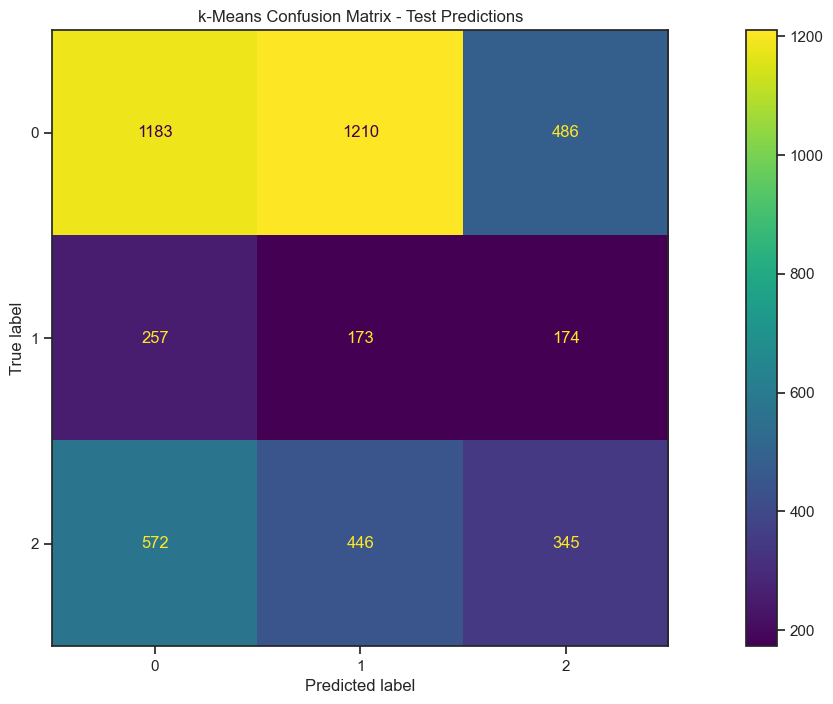

In [147]:
# Get an adjusted label set given the NMF-derived labelorer found above
perm_ref = list(range(len(np.unique(y_test_skf))))
true_labs = np.unique(y_test_skf)
yp_adj = [list(test_labelorder.values())[np.where(perm_ref == label_i)[0][0]] for label_i in y_pred_skf]
ytdf_num = [perm_ref[np.where(true_labs == ytdf_i)[0][0]] for ytdf_i in y_test_skf]

# Use sklearn's ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true = ytdf_num, y_pred = yp_adj)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = test_labelorder.keys())
disp.plot(values_format='')
plt.title('k-Means Confusion Matrix - Test Predictions')
plt.show()

##### Now, as noted above, let's see what happens when we re-optimize some of the hyperparameters here. The results do improve, however in the end it just seems like KMeans is nowhere near as performative here as we would hope, at least or particularly in comparison to the NMF results. This is somewhat of a good result - it tempers a bit the worry that the results are overly sensitive to the hyperparameter choices.

In [148]:
results = []

for mfv in max_feature_vec:
    for mdv in min_df_vec:
        for mxv in max_df_vec:
                    
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
            skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])
            
            tfidvec = TfidfVectorizer(sublinear_tf=True,
                                      max_features=mfv,
                                      min_df=mdv,
                                      max_df=mxv,
                                      norm='l2', 
                                      encoding='latin-1', 
                                      ngram_range=(1, 2), 
                                      stop_words='english')
            
            kmeans = KMeans(n_clusters = n_topics, 
                            init = 'k-means++', 
                            random_state = 0,
                            n_init = 'auto')
            
            y_test_skf = []
            y_pred_skf = []
            
            for train_index, test_index in skf_split:
                x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
                y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
                # Fit the tfidf model to the iteration's training data and also create testing features
                train_features = tfidvec.fit_transform(x_train_fold).toarray() 
                test_features = tfidvec.transform(x_test_fold).toarray() 
                # Fit the kMeans model to the training tf-idf vector
                kmeans.fit(train_features)
                # Use the fitted kMeans model to predict based on the test tf-idf vector
                kmeans_predict = kmeans.predict(test_features)
                y_pred_skf.extend(kmeans_predict)
                y_test_skf.extend(y_test_fold)

            labelorder, acc = label_permute_compare(y_test_skf, y_pred_skf, n_topics)

            results.append((mfv, mdv, mxv, acc))

print(max(results, key=lambda x:x[3]))

(3000, 3, 0.8, 0.48638052001650844)


In [149]:
# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])

# Set up tf-idf vectorizer. We start with some arbitrary choices of the hyperparameters max_features, min_df, and max_df, but will revisit these later.
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          max_features=3000,
                          min_df=3,
                          max_df=0.8,
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')

# Set up K-Means algorithm to train
kmeans = KMeans(n_clusters = n_topics, 
                init = 'k-means++', 
                random_state = 0,
               n_init = 'auto')

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using kmeans, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the tfidf model to the iteration's training data and also create testing features
    train_features = tfidvec.fit_transform(x_train_fold).toarray() 
    test_features = tfidvec.transform(x_test_fold).toarray() 
    # Fit the kmeans model to the training tf-idf vector
    kmeans.fit(train_features)
    # Use the fitted kmeans model to predict based on the test tf-idf vector
    kmeans_predict = kmeans.predict(test_features)
    y_pred_skf.extend(kmeans_predict)
    y_test_skf.extend(y_test_fold)

In [150]:
labelorder, acc = label_permute_compare(y_test_skf, y_pred_skf)
print(labelorder, acc)

{0: 1, 1: 0, 2: 2} 0.48638052001650844


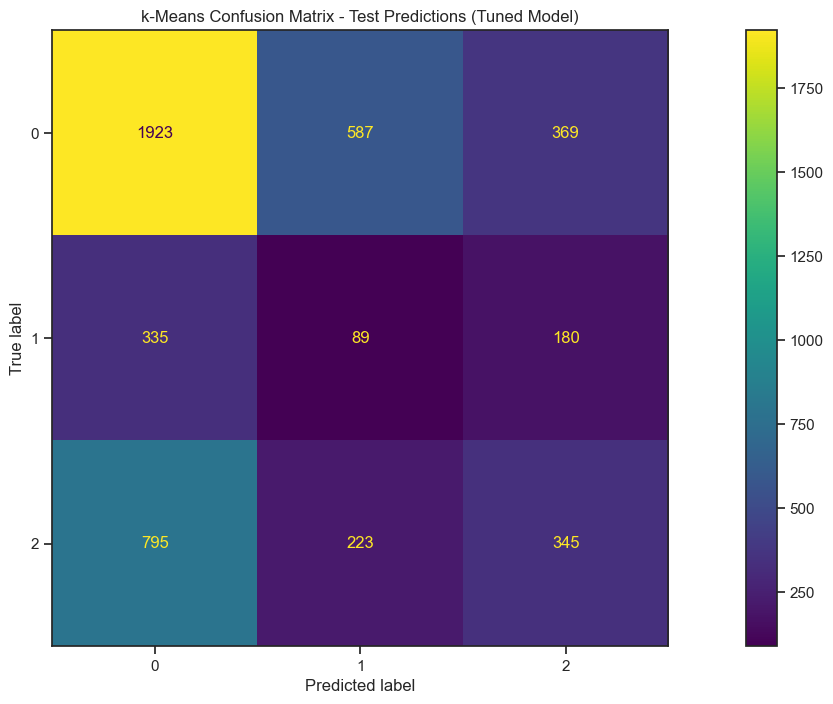

In [152]:
# Get an adjusted label set given the NMF-derived labelorer found above
perm_ref = list(range(len(np.unique(y_test_skf))))
true_labs = np.unique(y_test_skf)
yp_adj = [list(test_labelorder.values())[np.where(perm_ref == label_i)[0][0]] for label_i in y_pred_skf]
ytdf_num = [perm_ref[np.where(true_labs == ytdf_i)[0][0]] for ytdf_i in y_test_skf]

# Use sklearn's ConfusionMatrixDisplay
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true = ytdf_num, y_pred = yp_adj)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = test_labelorder.keys())
disp.plot(values_format='')
plt.title('k-Means Confusion Matrix - Test Predictions (Tuned Model)')
plt.show()

#### 2c) Supervised Learning: k-Nearest-Neighbors (KNN)

##### Now let's train some supervised models. It turns out that KNN does quite well and comparable to the unsupervised models above.

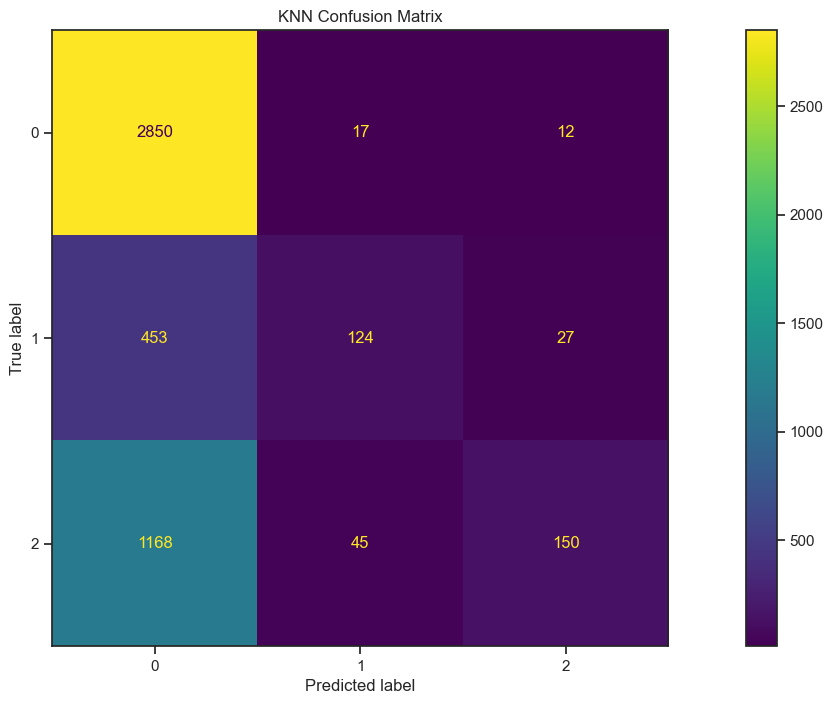

KNN Model Accuracy: 0.6446553858852662


In [153]:
def calculate_accuracy(y_true, y_pred):
    return sklearn.metrics.accuracy_score(y_true, y_pred)

# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])

# Set up tf-idf vectorizer. We start with some arbitrary choices of the hyperparameters max_features, min_df, and max_df, but will revisit these later.
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          max_features=3000,
                          min_df=2,
                          max_df=0.8,
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')

# KNN model with arbitrarily chosen 5 neighbors
knn_cv = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using KNN, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the tfidf model to the iteration's training data and also create testing features
    train_features = tfidvec.fit_transform(x_train_fold).toarray() 
    test_features = tfidvec.transform(x_test_fold).toarray() 
    # Fit the KNN model to the training tf-idf vector
    knn_cv.fit(train_features, y_train_fold)
    # Use the fitted KNN model to predict based on the test tf-idf vector
    knn_predict = knn_cv.predict(test_features)
    y_pred_skf.extend(knn_predict)
    y_test_skf.extend(y_test_fold)

model_classes = knn_cv.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("KNN Confusion Matrix")
plt.show()
# Check accuracy statistics
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'KNN Model Accuracy: {acc1}')

#### 2d) Supervised Learning: AdaBoosted Decision Tree Classifier

##### AdaBoost also performs in line with the KNN and NMF models.

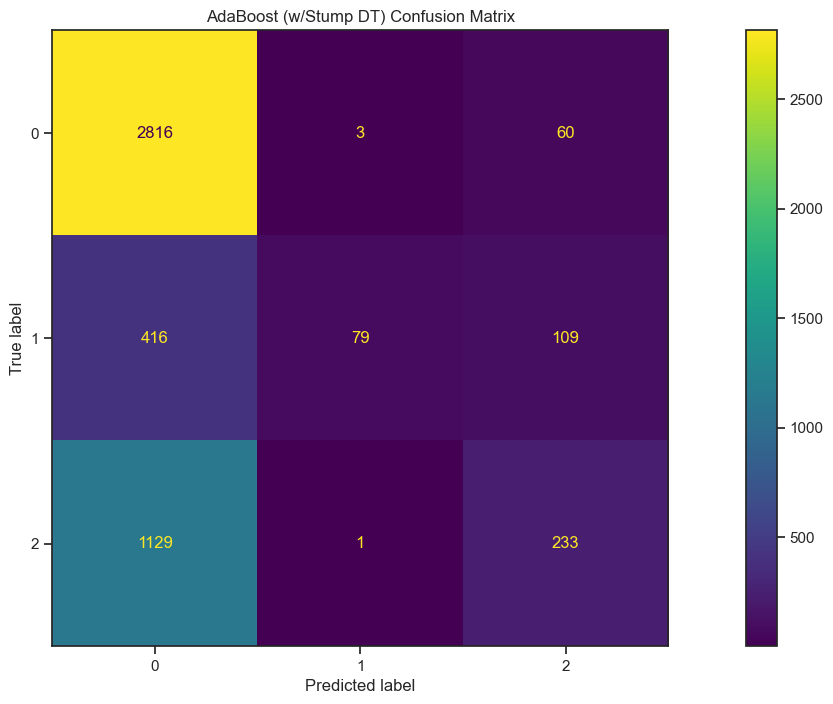

AdaBoost (w/Stump DT) Model Accuracy: 0.6454808089145687


In [154]:
# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])

# Set up tf-idf vectorizer. We start with some arbitrary choices of the hyperparameters max_features, min_df, and max_df, but will revisit these later.
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          max_features=3000,
                          min_df=2,
                          max_df=0.8,
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')

# AdaBoost classifier with stump decision tree
dt = DecisionTreeClassifier(max_depth=1)
ada_cv = AdaBoostClassifier(n_estimators=100, estimator=dt, learning_rate=1, random_state=1, algorithm='SAMME')

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using AdaBoost, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the tfidf model to the iteration's training data and also create testing features
    train_features = tfidvec.fit_transform(x_train_fold).toarray() 
    test_features = tfidvec.transform(x_test_fold).toarray() 
    # Fit the AdaBoost model to the training tf-idf vector
    ada_cv.fit(train_features, y_train_fold)
    # Use the fitted AdaBoost model to predict based on the test tf-idf vector
    ada_predict = ada_cv.predict(test_features)
    y_pred_skf.extend(ada_predict)
    y_test_skf.extend(y_test_fold)

model_classes = ada_cv.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("AdaBoost (w/Stump DT) Confusion Matrix")
plt.show()
# Check accuracy statistics
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'AdaBoost (w/Stump DT) Model Accuracy: {acc1}')

#### 2e) Supervised Learning: Multinomial Naive Bayes Classifier

##### Finally, here is a multinomial naive bayes classifier, which is a very popular choice for this kind of natural language processing problem. This ends up being the best performing model so far.

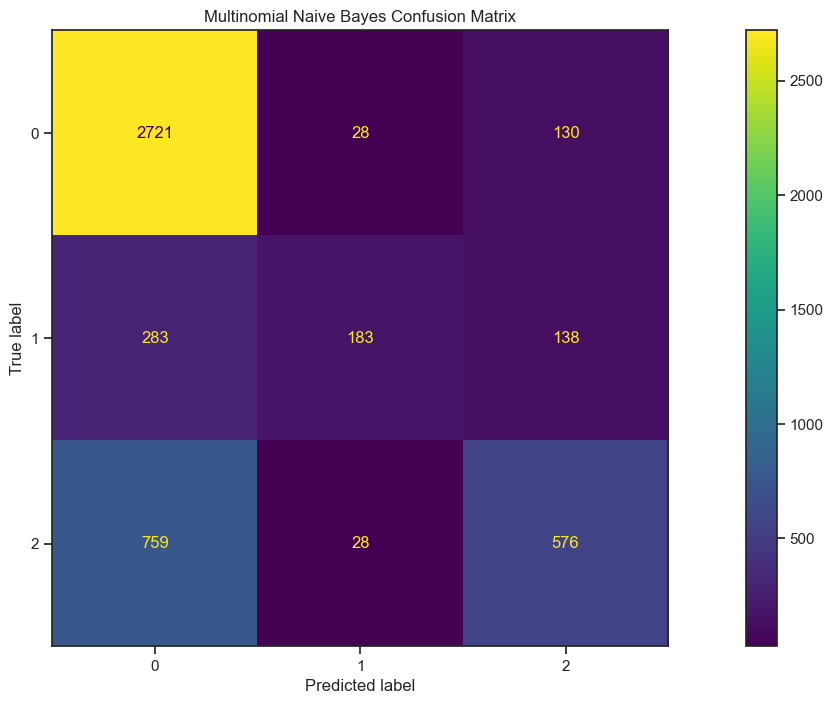

Multinomial Naive Bayes Model Accuracy: 0.7181180354931903


In [155]:
# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])

# Set up tf-idf vectorizer. We start with some arbitrary choices of the hyperparameters max_features, min_df, and max_df, but will revisit these later.
tfidvec = TfidfVectorizer(sublinear_tf=True,
                          max_features=3000,
                          min_df=2,
                          max_df=0.8,
                          norm='l2', 
                          encoding='latin-1', 
                          ngram_range=(1, 2), 
                          stop_words='english')

# Multinomial Naive Bayes classifier
mnb_cv = MultinomialNB()

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using MNB, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the tfidf model to the iteration's training data and also create testing features
    train_features = tfidvec.fit_transform(x_train_fold).toarray() 
    test_features = tfidvec.transform(x_test_fold).toarray() 
    # Fit the MNB model to the training tf-idf vector
    mnb_cv.fit(train_features, y_train_fold)
    # Use the fitted MNB model to predict based on the test tf-idf vector
    mnb_predict = mnb_cv.predict(test_features)
    y_pred_skf.extend(mnb_predict)
    y_test_skf.extend(y_test_fold)

model_classes = mnb_cv.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Multinomial Naive Bayes Confusion Matrix")
plt.show()
# Check accuracy statistics
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Multinomial Naive Bayes Model Accuracy: {acc1}')

##### Now take a look at the hyperparameter choices. By an amazing coincidence, it looks like our original model was the optimal model. However, it's also worth noting that all the naive bayes models perform very well in comparison to the other models we have considered above, with the worst hyperparameter choices still achieving accuracies of about 66%.

In [158]:
max_feature_vec = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
min_df_vec = [1, 2, 3, 4, 5, 10]
max_df_vec = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]

results = []

for mfv in max_feature_vec:
    for mdv in min_df_vec:
        for mxv in max_df_vec:
                    
            skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
            skf_split = skf.split(train_data['Text_Lemmatized'], train_data['sentimentId'])
            
            tfidvec = TfidfVectorizer(sublinear_tf=True,
                                      max_features=mfv,
                                      min_df=mdv,
                                      max_df=mxv,
                                      norm='l2', 
                                      encoding='latin-1', 
                                      ngram_range=(1, 2), 
                                      stop_words='english')
            
            mnb_cv = MultinomialNB()
            
            y_test_skf = []
            y_pred_skf = []
            
            for train_index, test_index in skf_split:
                x_train_fold, x_test_fold = np.array(train_data['Text_Lemmatized'])[train_index], np.array(train_data['Text_Lemmatized'])[test_index]
                y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
                # Fit the tfidf model to the iteration's training data and also create testing features
                train_features = tfidvec.fit_transform(x_train_fold).toarray() 
                test_features = tfidvec.transform(x_test_fold).toarray() 
                # Fit the MNB model to the training tf-idf vector
                mnb_cv.fit(train_features, y_train_fold)
                # Use the fitted MNB model to predict based on the test tf-idf vector
                mnb_predict = mnb_cv.predict(test_features)
                y_pred_skf.extend(mnb_predict)
                y_test_skf.extend(y_test_fold)

            labelorder, acc = label_permute_compare(y_test_skf, y_pred_skf, n_topics)

            results.append((mfv, mdv, mxv, acc))

            print((mfv, mdv, mxv, acc))

print(max(results, key=lambda x:x[3]))

(100, 1, 0.5, 0.6652909616178292)
(100, 1, 0.6, 0.6652909616178292)
(100, 1, 0.7, 0.6652909616178292)
(100, 1, 0.8, 0.6652909616178292)
(100, 1, 0.9, 0.6652909616178292)
(100, 1, 0.95, 0.6652909616178292)
(100, 1, 0.98, 0.6652909616178292)
(100, 2, 0.5, 0.6667354519191085)
(100, 2, 0.6, 0.6667354519191085)
(100, 2, 0.7, 0.6667354519191085)
(100, 2, 0.8, 0.6667354519191085)
(100, 2, 0.9, 0.6667354519191085)
(100, 2, 0.95, 0.6667354519191085)
(100, 2, 0.98, 0.6667354519191085)
(100, 3, 0.5, 0.6663227404044573)
(100, 3, 0.6, 0.6663227404044573)
(100, 3, 0.7, 0.6663227404044573)
(100, 3, 0.8, 0.6663227404044573)
(100, 3, 0.9, 0.6663227404044573)
(100, 3, 0.95, 0.6663227404044573)
(100, 3, 0.98, 0.6663227404044573)
(100, 4, 0.5, 0.6665290961617829)
(100, 4, 0.6, 0.6665290961617829)
(100, 4, 0.7, 0.6665290961617829)
(100, 4, 0.8, 0.6665290961617829)
(100, 4, 0.9, 0.6665290961617829)
(100, 4, 0.95, 0.6665290961617829)
(100, 4, 0.98, 0.6665290961617829)
(100, 5, 0.5, 0.6657036731324804)
(100, 

## 3) Modelling - Word2Vec Semantic Embeddings

##### Finally, I wanted to look at a feature generation/selection method other than tf-idf. For this I will use GenSim's (Google) Word2Vec model, which uses semantic embeddings. A Google search can bring you to any number of summaries about embeddings, and embeddings vs tf-idf, but here's one such: https://medium.com/@tam.tamanna18/exploring-the-power-of-nlp-why-embeddings-usually-outperform-tf-idf-98742e7b0bce

##### We first need to just split the texts into vectors for the input into gensim's model

In [159]:
split_text=[]
for text in train_data['Text_Lemmatized']:
    split_text.append(text.split())

split_text[:1]

[['gran', 'company', 'plan', 'production', 'russia', 'company', 'growing']]

##### Train the word2vec model

In [160]:
vector_size=100

In [161]:
w2v_model=Word2Vec(sentences=split_text, vector_size=vector_size, window=5, min_count=3, workers=4)

##### Let's take a look at one of these vectors just for funsies

In [113]:
vector = w2v_model.wv['company']  # get numpy vector of a word
vector

array([-0.43835396,  0.72789687,  0.34660247,  0.05448792,  0.2429885 ,
       -0.9301349 ,  0.18907325,  1.320354  , -0.3215485 , -0.27350843,
       -0.5936269 , -0.8100531 ,  0.19346248,  0.638797  , -0.23393036,
       -0.7007428 ,  0.13066714, -0.6126895 , -0.10032809, -1.2118453 ,
        0.58995646,  0.21648327,  0.6398585 , -0.26287013, -0.06346631,
       -0.29519513, -0.51310736, -0.25642845, -0.5927578 ,  0.11987162,
        1.0479155 ,  0.37369415,  0.6277283 , -0.5319732 , -0.551636  ,
        0.7614661 , -0.23400101, -0.4340737 , -0.326141  , -1.3899218 ,
        0.03468832, -0.3964156 , -0.13204782, -0.02264394,  0.26197326,
       -0.40029556, -0.53922594, -0.07784214,  0.25608918,  0.4888641 ,
        0.23186119, -0.48617655, -0.31623366, -0.26474404, -0.49180123,
        0.0071664 ,  0.31419703, -0.25376505, -0.9844697 ,  0.27016792,
        0.23010212,  0.14320308,  0.09799829, -0.05819113, -0.66407245,
        0.3471238 ,  0.2572987 ,  0.42810047, -0.9767462 ,  0.64

##### Now we need to process each text into a single feature vector. As shown above, we have a problem here in that each word's semantic embedding is itself a vector, and so a text will be a higher dimensional object that cannot be easily shoved into a model like Multinomial Naive Bayes. What we will do here is average over the semantic embeddings for each word in a text. IMPORTANTLY, I HAVE NO IDEA IF THIS IS A GOOD PRACTICE, OR IF IT ENDS UP IN A SENSE AVERAGING AWAY ALL THE INFORMATIONAL VALUE IN EACH WORD'S SEMANTIC EMBEDDINGS. It's simply one way to allow us to transform the embeddings into useable features.

In [162]:
modelled_vocab = w2v_model.wv.key_to_index

In [163]:
wdv_features = [];
for st in split_text:
    sent_vec = np.zeros(vector_size)
    cnt_words =0;
    for word in st:
        if word in modelled_vocab:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    wdv_features.append(sent_vec)

In [164]:
print(len(wdv_features))
print(len(wdv_features[0]))

4846
100


In [165]:
len(train_features) + len(test_features)

4846

##### We need to scale the features since semantic embeddigs, as seen above, take on negative values.

In [166]:
scaler = MinMaxScaler()
wdv_features_normalized = scaler.fit_transform(wdv_features)

##### Now, finally, we can use the features in a Multinomial Naive Bayes model. The results are actually not great, and worse than the tf-idf based features results. As I said above, this could easily be due to the way I used the semantic embeddings, but my goal here was simply to familiarize myself with word2vec, and hopefully this is a good launching point for me to tune these results.

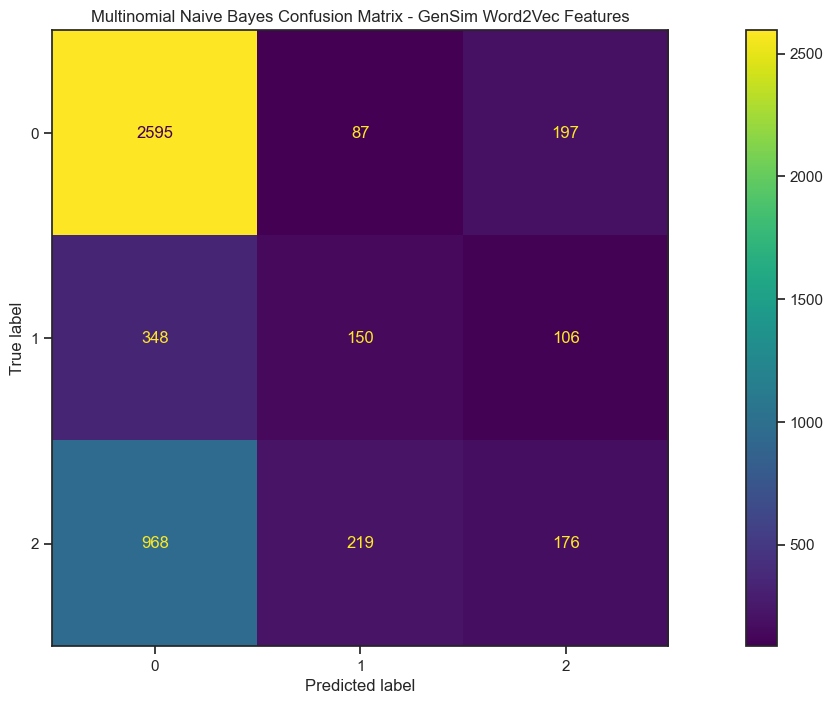

Multinomial Naive Bayes Model w/GenSim Word2Vec Features Accuracy: 0.6027651671481634


In [167]:
# Create StratifiedKFold object. MAKE SURE TO SET A RANDOM STATE SO THE SPLITS ARE REPEATABLE.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf_split = skf.split(wdv_features_normalized, train_data['sentimentId'])

# Multinomial Naive Bayes classifier
mnb_cv = MultinomialNB()

# Storage objects for k-fold iterations
y_test_skf = []
y_pred_skf = []

# Iterate through the k-folds using MNB, and store the test predictions
for train_index, test_index in skf_split:
    x_train_fold, x_test_fold = np.array(wdv_features_normalized)[train_index], np.array(wdv_features_normalized)[test_index]
    y_train_fold, y_test_fold = train_data['sentimentId'][train_index], train_data['sentimentId'][test_index]
    # Fit the MNB model to the training word2vec features
    mnb_cv.fit(x_train_fold, y_train_fold)
    # Use the fitted MNB model to predict based on the test word2vec features
    mnb_predict = mnb_cv.predict(x_test_fold)
    y_pred_skf.extend(mnb_predict)
    y_test_skf.extend(y_test_fold)

model_classes = mnb_cv.classes_
cnf_pred = sklearn.metrics.confusion_matrix(y_test_skf, y_pred_skf, labels=model_classes)
disp = ConfusionMatrixDisplay(cnf_pred, display_labels=model_classes)
disp.plot()
plt.title("Multinomial Naive Bayes Confusion Matrix - GenSim Word2Vec Features")
plt.show()
# Check accuracy statistics
acc1 = calculate_accuracy(y_test_skf, y_pred_skf)
print(f'Multinomial Naive Bayes Model w/GenSim Word2Vec Features Accuracy: {acc1}')